In [1]:
import matplotlib.pyplot as plt
import numpy as np
import hdstats
import joblib

In [168]:
import DEADataHandling
import datacube

dc = datacube.Datacube(app='landchar')

# boi = ('nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1', 
#        'nbart_swir_2', 'nbart_swir_3')

boi = ('nbart_blue', 'nbart_green', 'nbart_red', 'nbart_red_edge_1', 'nbart_red_edge_2', 
       'nbart_red_edge_3', 'nbart_nir_1', 'nbart_nir_2', 'nbart_swir_2', 'nbart_swir_3')

query = {'x':(144.4, 144.5), 'y':(-36.4, -36.5), 
         'time':('2018-01-01', '2018-12-31'), 
         'output_crs': 'EPSG:3577', 
         'resolution': (-20, 20)}

gds = DEADataHandling.load_clearsentinel2(dc=dc, query=query,
                                         bands_of_interest=boi,
                                         masked_prop=0,
                                         mask_pixel_quality=True)

Loading s2a pixel quality
    Loading 33 filtered s2a timesteps
Loading s2b pixel quality
    Loading 36 filtered s2b timesteps
Combining and sorting s2a, s2b data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [169]:
data = gds[list(gds.data_vars)].to_array().transpose('y', 'x','variable', 'time').values.astype(np.float32)
data[data == 0] = np.nan
data /= 10000.

dayofyear = np.array(gds.time.dt.dayofyear)
ts = dayofyear/365.

In [170]:
import s2cloudmask as s2cm

s2cm.mask_cloud_as_nan(data)

/g/data/v10/public/modules/dea-env/20190522/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.2 when using version 0.21.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [172]:
data = data[200:400,200:400,:,:]

In [319]:
data[:,:,:,37:42] = np.nan

In [2]:
data = joblib.load('../tests/landchar-small.pkl')
dayofyear = np.linspace(0, 365, num=data.shape[-1]) # fake dates

In [173]:
obs_ndvi = (data[:,:,3,:]-data[:,:,2,:])/(data[:,:,3,:]+data[:,:,2,:])

In [322]:
data = hdstats.completion(data, s=2)

In [323]:
ndvi = (data[:,:,3,:]-data[:,:,2,:])/(data[:,:,3,:]+data[:,:,2,:])
ndwi = (data[:,:,4,:]-data[:,:,3,:])/(data[:,:,4,:]+data[:,:,3,:])

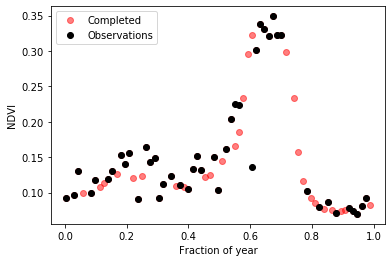

In [330]:
yloc, xloc = data.shape[0]//4, data.shape[1]//4
ts = dayofyear/365.
plt.plot(ts, ndvi[yloc,xloc,:], 'ro', alpha=0.5, label='Completed')
plt.plot(ts, obs_ndvi[yloc,xloc,:], 'ko', label='Observations')
plt.xlabel('Fraction of year')
plt.ylabel('NDVI')
plt.legend();

In [331]:
np.count_nonzero(np.isnan(data))

0

In [332]:
gm = hdstats.nangeomedian_pcm(data)

Automatically using 56 threads.


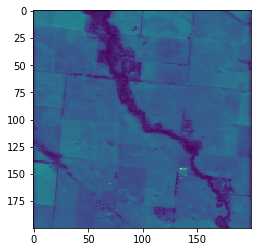

In [333]:
plt.imshow(gm[:,:,0])

In [334]:
mm = np.nanmean(data, axis=3)

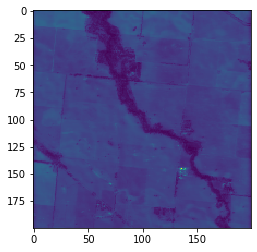

In [335]:
plt.imshow(mm[:,:,0])

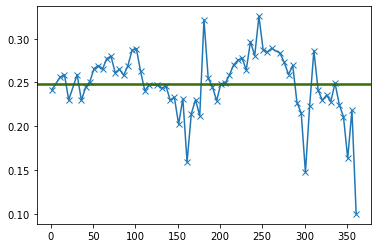

In [336]:
plt.plot(dayofyear, data[yloc,xloc,4,:], marker='x')
plt.axhline(gm[yloc,xloc,4], c='r')
plt.axhline(mm[yloc,xloc,4], c='g')

In [484]:
cdts = hdstats.cosdist(data, gm)

Automatically using 56 threads.


In [338]:
edts = hdstats.eucdist(data, gm)

Automatically using 56 threads.


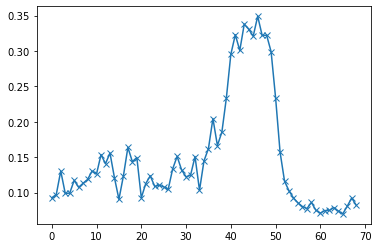

In [339]:
plt.plot(ndvi[yloc,xloc,:], marker='x')

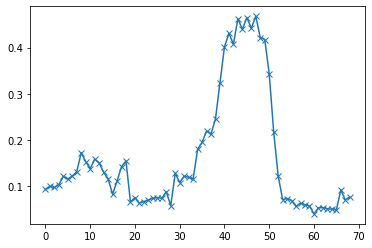

In [340]:
plt.plot(ndwi[yloc,xloc,:], marker='x')

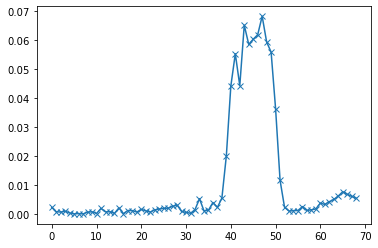

In [341]:
plt.plot(cdts[yloc,xloc,:], marker='x')

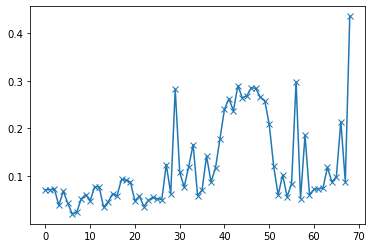

In [342]:
plt.plot(edts[yloc,xloc,:], marker='x')

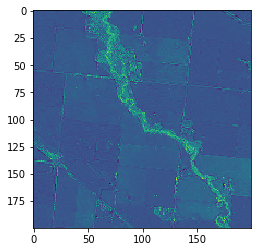

In [343]:
plt.imshow(ndvi[:,:,0]);

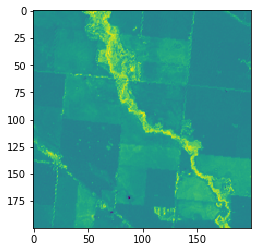

In [344]:
plt.imshow(ndwi[:,:,0]);

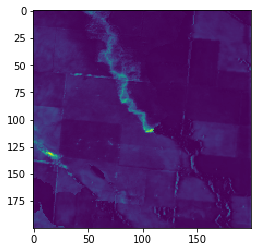

In [345]:
plt.imshow(cdts[:,:,15]);

In [346]:
def imshow(data, fs=6, pc=2):
    img = data.copy()
    plt.figure(figsize=(fs,fs*(img.shape[0]/img.shape[1])))

    if len(img.shape) == 3:
        for i in range(min(3, img.shape[2])):
            dd=img[:,:,i]
            pl, pu = np.percentile(dd[np.isfinite(dd)], (pc,100-pc))
            dd[dd<pl], dd[dd>pu] = pl, pu
            dd -= pl
            dd /= (pu - pl)
        plt.imshow(img, aspect='auto')
    else:
        pl, pu = np.percentile(img[np.isfinite(img)], (pc,100-pc))
        plt.imshow(img, aspect='auto', vmin=pl, vmax=pu)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.tight_layout()

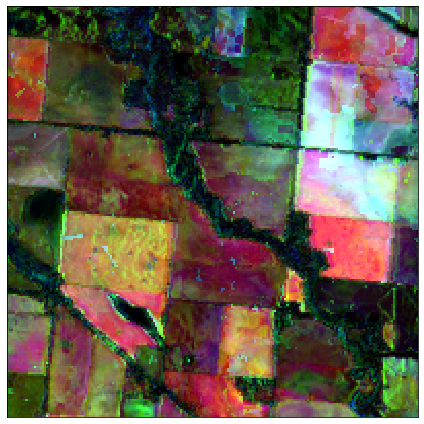

In [347]:
f1 = hdstats.fourier_std(cdts)
imshow(f1)

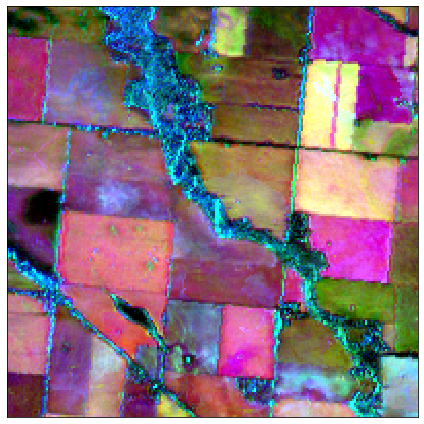

In [348]:
f2 = hdstats.fourier_mean(ndwi)
imshow(f2)

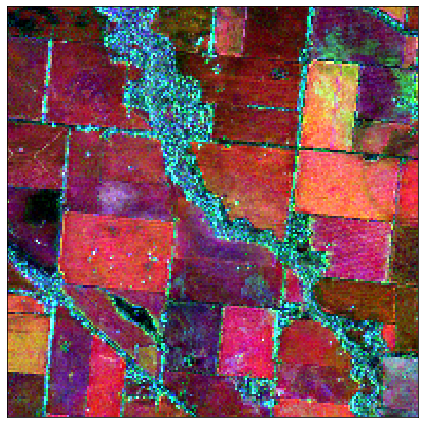

In [349]:
f3 = hdstats.fourier_median(ndvi)
imshow(f3)

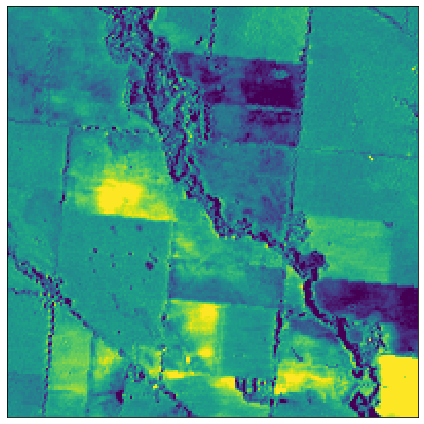

In [350]:
f4 = hdstats.mean_change(ndwi)
imshow(f4)

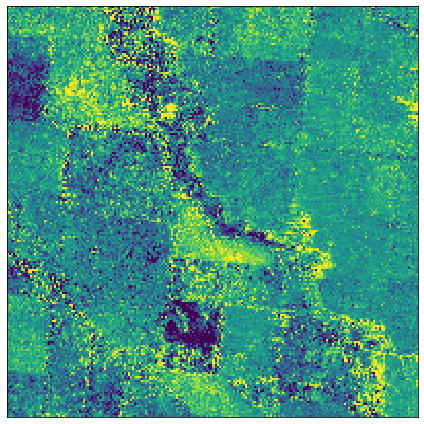

In [351]:
f5 = hdstats.median_change(ndwi)
imshow(f5)

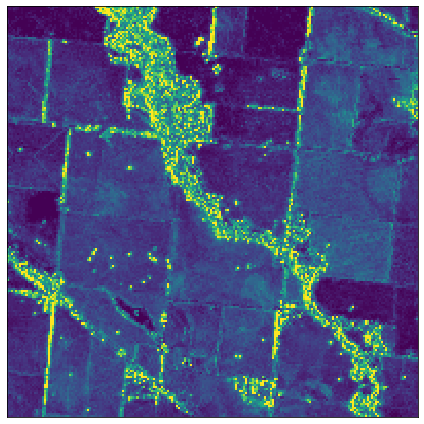

In [352]:
f6 = hdstats.mean_abs_change(ndvi)
imshow(f6)

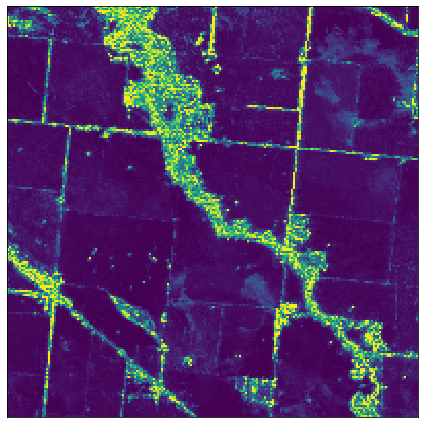

In [353]:
f7 = hdstats.complexity(ndvi)
imshow(f7)

In [354]:
f8 = hdstats.symmetry(data)

Automatically using 56 threads.


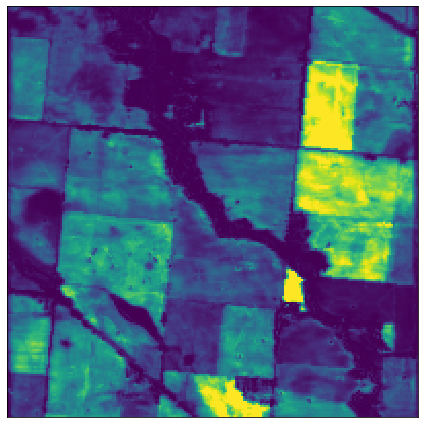

In [355]:
imshow(f8)

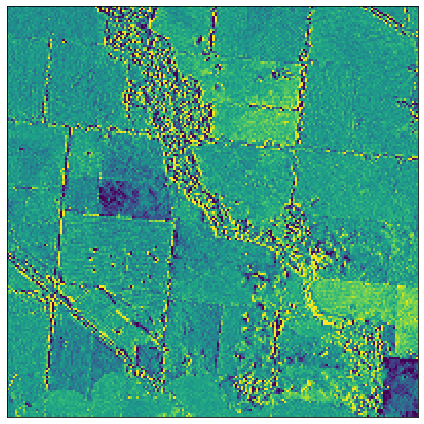

In [356]:
f9 = hdstats.mean_central_diff(ndvi)
imshow(f9)

In [357]:
mndvi = np.median(ndvi, axis=(0,1))

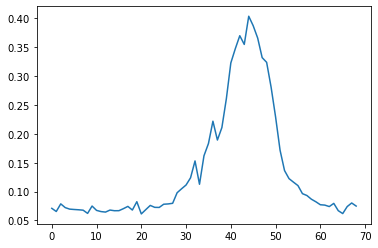

In [358]:
plt.plot(mndvi)

In [359]:
hdstats.number_peaks(mndvi[np.newaxis,np.newaxis,:], 100)

array([[1]], dtype=int8)

In [360]:
f10 = hdstats.number_peaks(ndvi, 100)

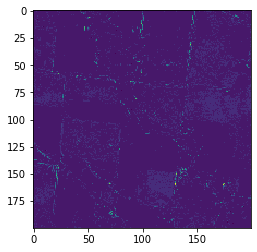

In [361]:
plt.imshow(f10)

In [362]:
f11 = hdstats.discordance(cdts)

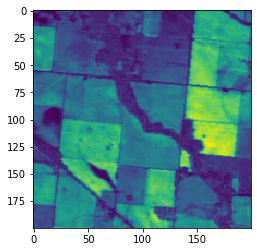

In [363]:
plt.imshow(f11)

In [364]:
f12 = hdstats.area_warp_similarity(cdts)

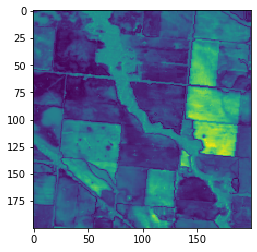

In [365]:
plt.imshow(f12)

In [366]:
img = np.dstack([f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12])

In [367]:
img[np.isnan(img)] = 0.0

In [368]:
np.count_nonzero(np.isnan(img))

0

In [369]:
A = img.reshape((-1, img.shape[-1]))

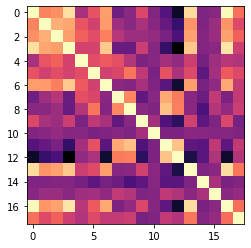

In [370]:
plt.imshow(np.corrcoef(A.T), cmap=plt.cm.magma)

In [371]:
X = img.reshape((-1, img.shape[-1])).copy()

In [372]:
X.shape

(40000, 18)

In [373]:
mask = np.isfinite(img).all(axis=2)

In [374]:
mask.shape

(200, 200)

In [375]:
img[mask] = 0.0

In [522]:
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FactorAnalysis

nfeatures = X.shape[1]
ninitclass = 20

pipeline = []

# pca = PCA(n_components=int(0.9*nfeatures), svd_solver="randomized", whiten=True)
# pipeline.append(("pca", pca))

gmm = GaussianMixture(n_components=ninitclass, covariance_type="diag", verbose=True, init_params="random")

pipeline.append(("gmm", gmm))

classifier = Pipeline(pipeline)

classifier.fit(X[mask.flat])

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


Pipeline(memory=None,
         steps=[('gmm',
                 GaussianMixture(covariance_type='diag', init_params='random',
                                 max_iter=100, means_init=None, n_components=20,
                                 n_init=1, precisions_init=None,
                                 random_state=None, reg_covar=1e-06, tol=0.001,
                                 verbose=True, verbose_interval=10,
                                 warm_start=False, weights_init=None))],
         verbose=False)

In [525]:
ppca = PCA(n_components=int(0.9*nfeatures), svd_solver="randomized", whiten=True)
drimg = ppca.fit_transform(X).reshape((img.shape[0],img.shape[1], pca.n_components))

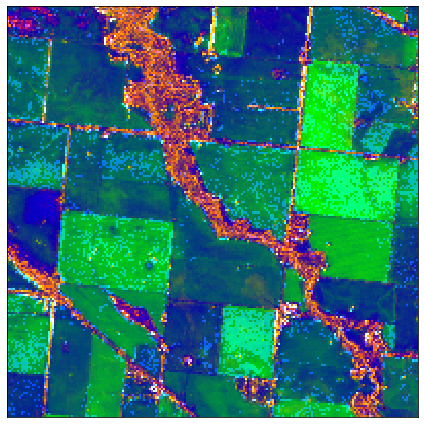

In [526]:
imshow(drimg[:,:,:3]);

In [454]:
labels = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
labels[mask] = classifier.predict(X[mask.flat])

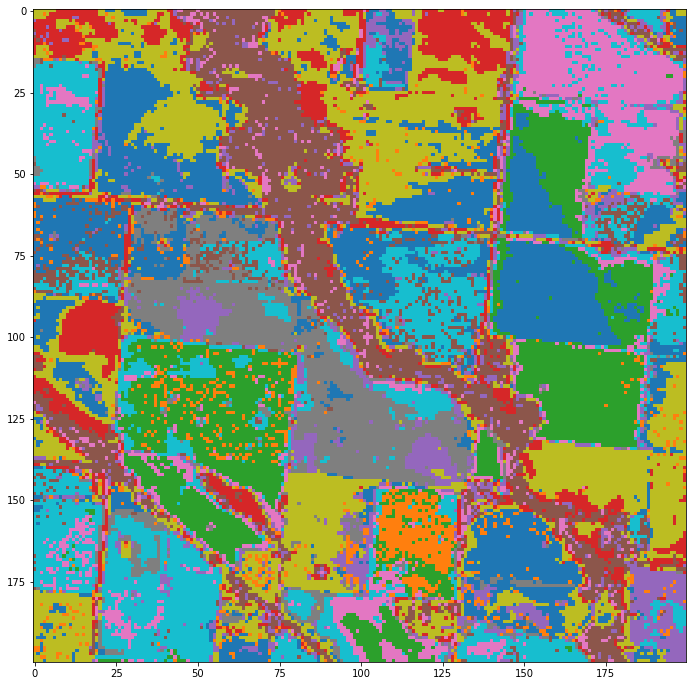

In [455]:
plt.figure(figsize=(12,12))
plt.imshow(labels, cmap=plt.cm.tab10)

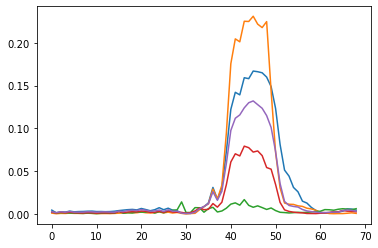

In [485]:
for i in np.unique(labels):
    plt.plot(np.median(cdts[labels==i,:], axis=0), label=i)
#plt.legend()

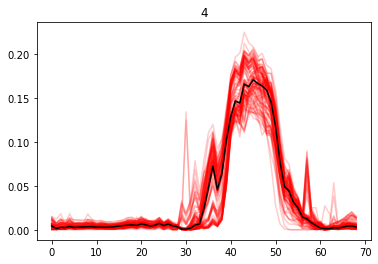

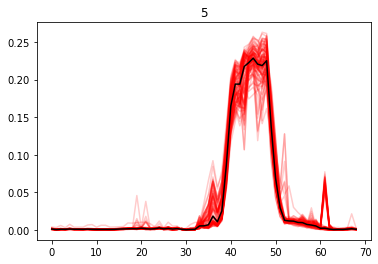

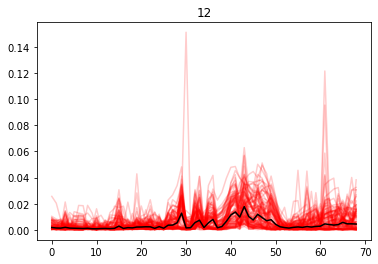

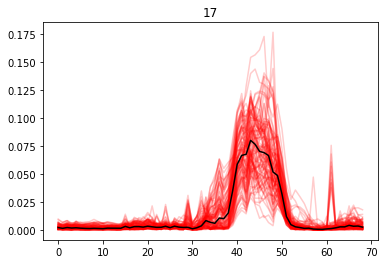

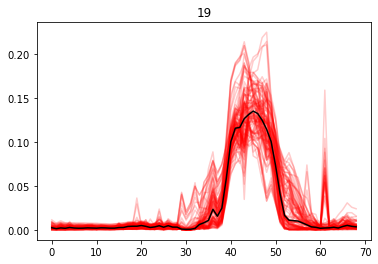

In [486]:
for k in np.unique(labels):
    series = cdts[labels==k,:]
    idxs = np.random.randint(0, series.shape[0], size=100)
    t = range(series.shape[1])
    plt.figure()
    for ts in series[idxs]:
        plt.plot(t, ts, color='r', alpha=0.2)
    plt.plot(t, np.median(series[idxs], axis=0), color='k')
    plt.title(k)

In [519]:
ndviphenos = [np.mean(ndvi[labels==i,:], axis=0).reshape(1,-1) for i in range(ninitclass)]

In [520]:
nndviphenos = len(ndviphenos)
DM = np.zeros((nndviphenos, nndviphenos))
for i in range(nndviphenos):
    for j in range(i, nndviphenos):
        DM[i,j] = hdstats.dtw_dist(ndviphenos[i], ndviphenos[j])
DM = DM + DM.T

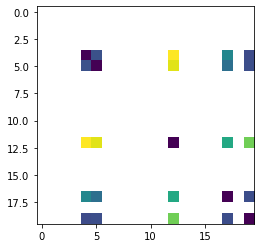

In [521]:
plt.imshow(DM)

In [502]:
phenos = [np.mean(cdts[labels==i,:], axis=0).reshape(1,-1) for i in range(ninitclass)]

In [503]:
nphenos = len(phenos)
DM = np.zeros((nphenos, nphenos))
for i in range(nphenos):
    for j in range(i, nphenos):
        DM[i,j] = hdstats.dtw_dist(phenos[i], phenos[j])
DM = DM + DM.T

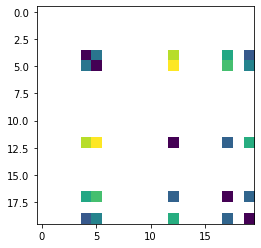

In [504]:
plt.imshow(DM)

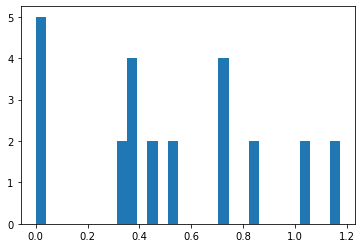

In [505]:
plt.hist(DM.flat, 30);

In [506]:
for i, j in np.argwhere(DM < 0.10):
    labels[labels == j] = i

In [507]:
classes = np.unique(labels)
print(len(classes), '::', classes)

5 :: [ 4  5 12 17 19]


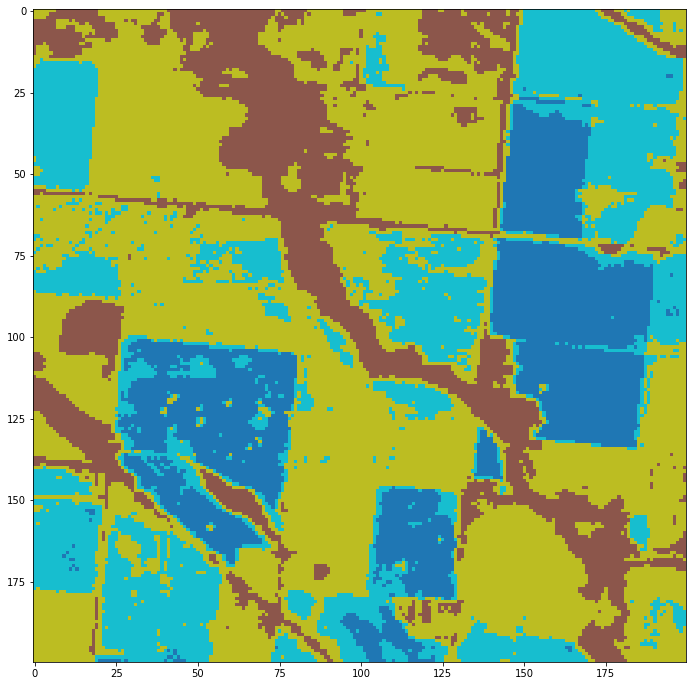

In [508]:
plt.figure(figsize=(12,12))
if len(classes) < 10:
    plt.imshow(labels, cmap=plt.cm.tab10)
else:
    plt.imshow(labels, cmap=plt.cm.tab20)

In [509]:
clabels = np.zeros_like(labels)
lbls = np.argsort([np.count_nonzero(labels == i) for i in np.unique(labels)])
for k in lbls:
    lmask = labels == k
    lmask = binary_closing(lmask, diamond(0))
    clabels[lmask] = k

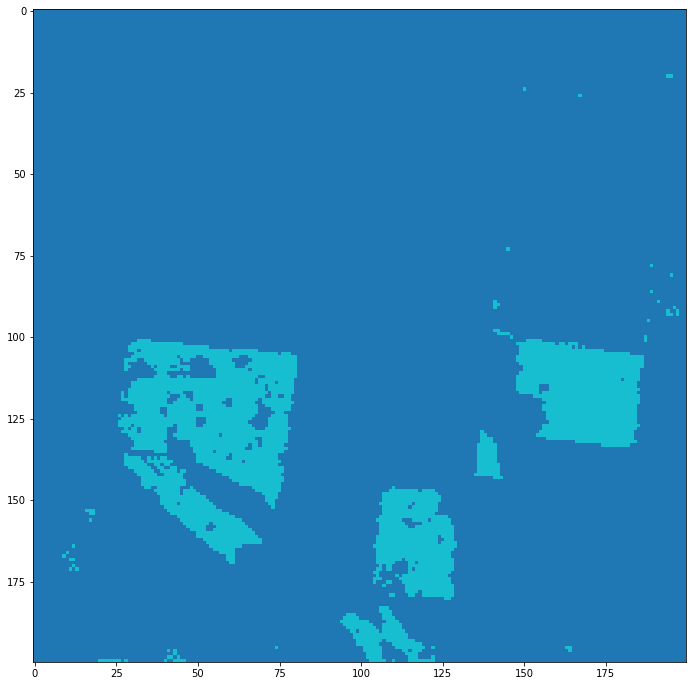

In [510]:
plt.figure(figsize=(12,12))
if len(classes) < 10:
    plt.imshow(clabels, cmap=plt.cm.tab10)
else:
    plt.imshow(clabels, cmap=plt.cm.tab20)

In [511]:
ntc = np.empty((ndvi.shape[0], ndvi.shape[1], len(phenos)), dtype=np.float32)
for k in range(ntc.shape[2]):
    print(k)
    for i in range(ntc.shape[0]):
        for j in range(ntc.shape[1]):
            ntc[i,j,k] = hdstats.dtw_dist(ndvi[i,j,:].reshape(1,-1), phenos[k])

mntc = np.argmin(ntc, axis=2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


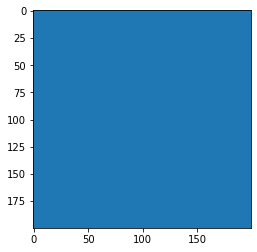

In [512]:
plt.imshow(mntc, cmap=plt.cm.tab20)

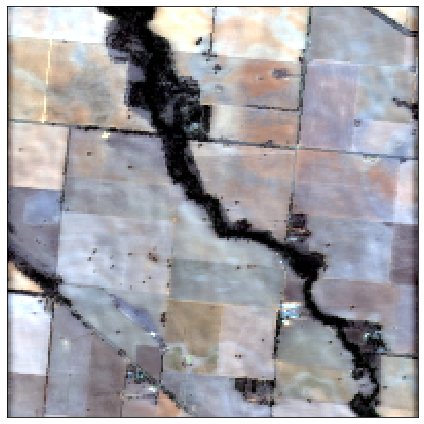

In [513]:
imshow(gm[:,:,[2,1,0]]);

In [514]:
from skimage.morphology import label, binary_closing, binary_opening, diamond, disk

In [515]:
dtwlabels = np.zeros_like(mntc)
lbls = np.argsort([np.count_nonzero(mntc == i) for i in np.unique(mntc)])
for k in lbls:
    lmask = mntc == k
    lmask = binary_closing(lmask, diamond(0))
    dtwlabels[lmask] = k

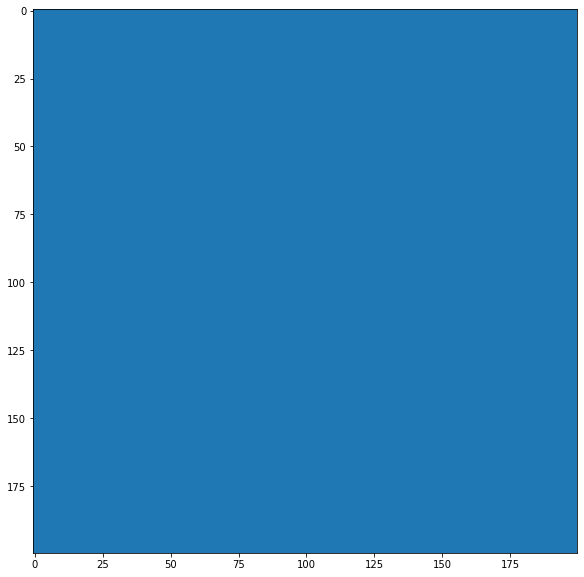

In [516]:
plt.figure(figsize=(10,10))
plt.imshow(dtwlabels, cmap=plt.cm.tab20)
#plt.colorbar()